# 운영체제 과제 01
- 201901763 이지호

과제 1
마감 : 4월 30일(일) 저녁 6시까지
내용 :
수업때 이야기한 모든 스케줄링 방법을 구현하고 성능(5가지) 비교
Json 파일로 입력정보를 주면 포맷을 체크해서 비교판단
실시간스케줄링과 비실시간스케줄링을 Json  입력파일로 자동 구분처리
파이썬만 사용, 간트차트 출력을 포함하여 5가지를 모두 비교하고, 각 입력 데이터에 대해 그 중 종합적으로 제일 나은 방법을 "자동" 결과 리포팅 (리포팅 내용을 간단한 설명을 포함하여 자동 생성)
숫자 결과와 그래픽결과를 모두 나타내고 자동으로 리포팅
chatGPT 포함한 외부 자료 사용 절대 금함. 특성을 이미 잘 알고 있으므로,  사용흔적이 보이면 0점 처리

MarkDown 문서로 설명과 해설 그리고 주석이 포함된 주피터노트북 파일(*.ipynb 파일) 과 해당 파일을 PDF 로 저장한 파일, 
입력에 사용하는 json 파일 3개 (입력예제 3개임) 등, 
총 5개를 이러닝 사이트에 제출함.

실행 결과는 절대 평가함. (제대로 되었는지 여부, 제출한 입력 포맷에 평가 데이터를 적용해서 진행)
전체 결과는 등급제로 상대 평가함. 열심히 코드 만들고, 열심히 최선의 결과를 잘 만든 사람에게 높은 등급

위 내용을 기준으로 추가로 필요한 부분은 스스로 판단해서 진행하면 됨. 의도에서 벗어나거나 축소되면 안됨.


- First-come, First-Served (선입선출)
- Shortest-Job-First (최단작업우선)
- Shortest-remaining-time-first (최단잔여시간우선)
- Priority (우선순위)
- Round robin(퀀텀타임대로 순회)
- Priority + Round robin

## Load data
- 아래 변수 숫자 (int) 변경해가며, (1), (2), (3)번 case 마다 실행 가능.

In [1232]:
# case_[NUM] 변경해가며 출력 가능
_casenum = 1

In [1233]:
import json
import matplotlib.pyplot as plt

def data_loader():
    _jsonfilename = "case" + str(_casenum) + ".json"
    with open(_jsonfilename) as f:
        json_object = json.load(f)

    num_of_processs = len(json_object['list'])
    print("Num of Process :", num_of_processs)

    # data checking
    assert json_object['list']
    for i in range(num_of_processs):
        assert json_object['list'][i]["Num"] > 0
        assert json_object['list'][i]["Burst_time"] >= 1
        assert json_object['list'][i]["Priority"] >= 0
        assert json_object['list'][i]["Arrival_time"] >= 0
    print("Data Loading Sucess")
    
    return json_object

## Function; draw Gantt chart in terminal

In [1234]:
_ALL_JOB_IS_DONE_ = -999
_NON_PROCESS_ = -1

def draw(_process, _order):
    _original_process_list = _process
    fig, ax = plt.subplots(figsize=(10, 1))

    _sum_of_busrt_time = 0
    _sum_of_response_time = 0
    _sum_of_turnaround_time = 0
    _sum_of_running_time = 0
    _now_time = 0
    _cumsum_waiting_time = 0

    _xlim_tickers = []

    for _pid, _runtime in _order:
        # P_num은 1부터 시작하기에, index 맞추는 용도.
        _pid -= 1
        # NOT CPU RUNNING
        if (_pid < 0):
            if (_runtime > 0):
                # TAKE A REST
                _now_time += _runtime
            elif (_runtime == _ALL_JOB_IS_DONE_):
                # ALL JOP IS DONE
                break
        # CPU RUNNING
        else:
            # First come in CPU
            if (_original_process_list[_pid]['Burst_time']==_process[_pid]['Burst_time']):
                _sum_of_response_time += _now_time
                print("START - P", _pid, ":", _now_time)
                # 원본의 Priority 시작시간 메모장으로 사용함.
                _original_process_list[_pid]['Priority'] = _now_time
            
            # if (_process[_pid]['Burst_time'] >= _runtime):
            _sum_of_busrt_time += _process[_pid]['Burst_time']
            _cumsum_waiting_time += _now_time
            
            ax.barh(0, _runtime, left=_now_time, edgecolor='black')
            _now_time += _runtime
            ax.text(_now_time - _runtime/2, 0, ('P'+str(_pid+1)), ha='center', va='center')
            
            # burst_time - running time
            _process[_pid]['Burst_time'] -= _runtime
            # JOP IS DONE ?
            if (_process[_pid]['Burst_time'] == 0):
                print("P", _pid, "Turnaround time is", _now_time - _process[_pid]['Arrival_time'])
                _sum_of_turnaround_time += _now_time - _process[_pid]['Arrival_time']
                print("P", _pid, "Running    time is", _now_time -
                      _original_process_list[_pid]['Priority'])
                _sum_of_running_time += _now_time - \
                    _original_process_list[_pid]['Priority']
                print("EXIT  - P", _pid, ":", _now_time)
        _xlim_tickers.append(_now_time)

    ax.set_xticks(_xlim_tickers)
    ax.set_xlim([0, _now_time])
    ax.set_yticks([])
    plt.show()

    # print value
    # cpu 이용률
    print("CPU utilization : %2.2f" % float(_sum_of_busrt_time/_now_time*100), "%")
    # 프로세스를 cpu가 실행하지 않은 평균 대기시간
    print("Average waiting time :", _cumsum_waiting_time/len(_process))
    # 프로세스를 처음으로 실행하는 데에 걸린 시간
    print("Average Response time :", _sum_of_response_time/len(_process))
    # 시작하고 나서부터 완료까지 걸린 시간
    print("Average Running time :", _sum_of_running_time/len(_process))
    # 처음 대기 부터, 작업 완료에 대한 총 소요 시간 / p's 종료시점 - arrival_time
    print("Average Turnaround time :", _sum_of_turnaround_time/len(_process))

## First-come, First-Served (선입선출)

Num of Process : 4
Data Loading Sucess
START - P 0 : 0
P 0 Turnaround time is 10
P 0 Running    time is 10
EXIT  - P 0 : 10
START - P 1 : 10
P 1 Turnaround time is 25
P 1 Running    time is 25
EXIT  - P 1 : 35
START - P 2 : 45
P 2 Turnaround time is 102
P 2 Running    time is 102
EXIT  - P 2 : 147
START - P 3 : 147
P 3 Turnaround time is 12
P 3 Running    time is 12
EXIT  - P 3 : 159


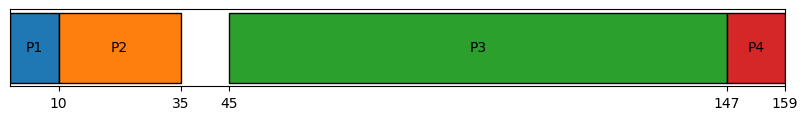

CPU utilization : 93.71 %
Average waiting time : 50.5
Average Response time : 50.5
Average Running time : 37.25
Average Turnaround time : 37.25


In [1235]:
_order = []
tmp = data_loader()
tmp = sorted(tmp['list'], key=lambda x: x['Arrival_time'])
for i in tmp:
    _order.append([i['Num'], i['Burst_time']])
_order.insert(2, [_NON_PROCESS_, 10])
_order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])

draw(tmp, _order)

## Priority First Served (우선순위먼저)

Num of Process : 4
Data Loading Sucess
[[4, 12], [2, 25], [-1, 10], [1, 10], [3, 102], [-1, -999]]
START - P 3 : 0
START - P 1 : 12
P 1 Turnaround time is 25
P 1 Running    time is 25
EXIT  - P 1 : 37
START - P 0 : 47
START - P 2 : 57


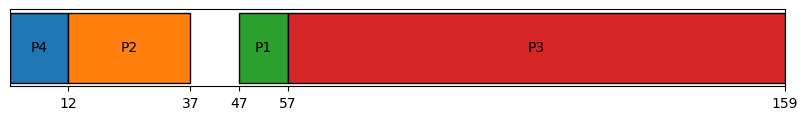

CPU utilization : 93.71 %
Average waiting time : 29.0
Average Response time : 29.0
Average Running time : 6.25
Average Turnaround time : 6.25


In [1236]:
_order = []
tmp = data_loader()
tmp = sorted(tmp['list'], key=lambda x: x['Priority'])
for i in tmp:
    _order.append([i['Num'], i['Burst_time']])
_order.insert(2, [_NON_PROCESS_, 10])
_order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
print(_order)
draw(tmp, _order)
